In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
#getting mean and sd 
from torchvision import datasets,transforms as T

#step1: load dataset with only ToTensor transform
train_ds = datasets.CIFAR10('CIFAR10/', train = True, download = True, transform=T.ToTensor())



Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/


In [3]:
#step2: append or collect all images in one empty list

train_imgs = torch.stack([train_imgs_t for train_imgs_t,_ in train_ds], dim=3)

In [4]:
train_imgs.shape

torch.Size([3, 32, 32, 50000])

In [5]:
# 3,32,32,5000 ---> 3,32*32*5000 --> mean

train_imgs.view(3,-1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [6]:
# 3,32,32,5000 ---> 3,32*32*5000 --> std

train_imgs.view(3,-1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [7]:
#For CIFAR-10 Dataset Channel mean is 0.4914, 0.4822, 0.4465
#Channel wise Standard Deviation is 0.2470, 0.2435, 0.2616


transform = T.Compose([
      T.ToTensor(),
      T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)) #since we have colored data so 3 channels mean 3 values 
])

In [8]:
train_ds = datasets.CIFAR10('CIFAR10/', train = True, download = True, transform= transform)
test_ds = datasets.CIFAR10('CIFAR10/', train = False, download = True, transform= transform)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
print("size of training dataset is {}".format(len(train_ds)))
print("size of test dataset is {}".format(len(test_ds)))

size of training dataset is 50000
size of test dataset is 10000


Plot examples from the dataset


In [10]:
#changing labels from numbers to their relative descriptions 

labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 32, 3])


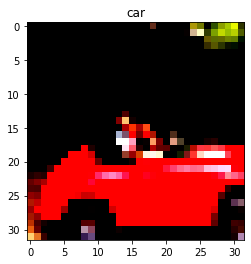

In [11]:
index = 99
image,label = train_ds[index]

image = image.permute(1,2,0) #change the image shape from C,H,W to H,W,C for plotting purposes. The axis of the channel is 0 and it changed from being on teh right to the left 

print(image.shape)

#if you want to plot the original image (not normalised), you apply image * std + mean

#image = image * torch.Tensor([0.2470, 0.2435, 0.2616]) + torch.Tensor([0.4914, 0.4822, 0.4465]) 

#we can see that the normalised image has black area as normalisation shifted the rgb levels above 0 to 1 range 

plt.imshow(image)
plt.title(labels[label]);

Load dataset into batches


In [12]:
from torch.utils.data import DataLoader, random_split

In [13]:
train_dataset, valid_dataset = random_split(train_ds, (45000,5000))

In [14]:
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_ds, batch_size=64, shuffle=True)

In [15]:
print("Total batches created in trainloader is {}".format(len(trainloader)))
print("Total batches created in trainloader is {}".format(len(validloader)))
print("Total batches created in trainloader is {}".format(len(testloader)))

print("Size of train dataset is {}".format(len(trainloader.dataset)))
print("Size of valid dataset is {}".format(len(validloader.dataset)))
print("Size of test dataset is {}".format(len(testloader.dataset)))

Total batches created in trainloader is 704
Total batches created in trainloader is 79
Total batches created in trainloader is 157
Size of train dataset is 45000
Size of valid dataset is 5000
Size of test dataset is 10000


In [16]:
dataiter = iter(trainloader)

images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


Create CNN


k : kernel_size or filters 
<br>
p : padding 
<br>
s : stride 
<br>
W : Width 
<br>
H : Height 

\begin{equation*}
For Same padding = \frac{k - 1}{2} \\
\end{equation*}

\begin{equation*}
W[next] = \frac{W[previous] + 2p - k}{s} + 1 \\
\end{equation*}

\begin{equation*}
H[next] = \frac{H[previous] + 2p - k}{s} + 1 \\
\end{equation*}

'''
3 x 32 x 32 (input)

       | k = (3,3), p = 1, s = 1 , out_channels = 16,operation = convolutional  #conv1
       V activation = relu 
       
16 x 32 x 32

       | k = (2,2), s = 2, operation = Max Pooling #maxpool
       V 
       
16 x 15 x 15

       | k = (3,3), p = 1, s = 1, out_channels = 32, operation = convolutional #conv2
       V activation = relu
       
32 x 15 x 15 

       | k = (2,2), s = 2, operation = Max Pooling #maxpool
       V 
       
32 x 8 x 8

       | k = (3,3), p = 1 , s = 1 , out_channels = 64, operation = convolutional #conv3
       V activation = relu 
       
64 x 8 x 8

       | k = (2,2), s = 2 , operation = MaxPooling #maxpool
       V

64 x 4 x  4
    
       |  operation = Flatten
       V
500

       |  linear,activation = relu #linear1
       V

128
       |  linear,activation = relu #linear2
       V

10  linear, activation = log_softmax #linear3
'''

In [17]:
from torch import nn
import torch.nn.functional as F

In [18]:
#in the init method you will define the layers and in the forward method you will use them to create the layer

class MyModel(nn.Module):

  def __init__(self):
    super(MyModel,self).__init__()

    self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3),padding=1,stride=1)
    self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3),padding=1,stride=1)
    self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3),padding=1,stride=1)
    self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)

    self.linear_1 = nn.Linear(in_features=1024,out_features=500) #first fully connected layer
    self.linear_2 = nn.Linear(in_features=500,out_features=128)
    self.linear_3 = nn.Linear(in_features=128,out_features=10)


  def forward(self,images):
    a1 = self.maxpool(F.relu(self.conv_1(images)))
    a2 = self.maxpool(F.relu(self.conv_2(a1)))
    a3 = self.maxpool(F.relu(self.conv_3(a2)))
    a3 = a3.view(a3.shape[0],-1) #change shape from 64,4,4 to 64*4*4
    a4 = F.relu(self.linear_1(a3))
    a5 = F.relu(self.linear_2(a4))
    a6 = F.log_softmax(self.linear_3(a5),dim=1) #we will use log softmax becasue the loss function we will use take the log

    return a6


In [19]:
model = MyModel()
model

MyModel(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=1024, out_features=500, bias=True)
  (linear_2): Linear(in_features=500, out_features=128, bias=True)
  (linear_3): Linear(in_features=128, out_features=10, bias=True)
)

In [20]:
from torchsummary import summary


In [21]:
summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                  [-1, 500]         512,500
            Linear-8                  [-1, 128]          64,128
            Linear-9                   [-1, 10]           1,290
Total params: 601,502
Trainable params: 601,502
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 2.29
Estimated Total Size (MB): 2.58
-------------------------------------------

In [23]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

def view_classify(img, ps):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(),cmap = 'gray')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

Train the model

In [24]:
from torch import optim
from tqdm import tqdm

criterion = nn.NLLLoss() #(logps, true_labels) that's why we applied log softmax layer instead of softmax layer
optimizer = optim.Adam(model.parameters(), lr=0.003)
epochs = 10

In [25]:
for i in range(epochs):

  train_loss = 0.0
  train_acc = 0.0
  valid_loss = 0.0
  valid_acc = 0.0

  model.train()
  
  for images,labels in tqdm(trainloader):

    logps = model(images) #output ps

    loss = criterion(logps,labels)

    optimizer.zero_grad()
    loss.backward() #dw,db
    optimizer.step() #w=w-lr*dw

    train_loss += loss.item()
    ps = torch.exp(logps) #log_softmax --> softmax
    train_acc += multiclass_accuracy(ps,labels)

  model.eval() #dropout, batch norm

  for images,labels in tqdm(validloader):

    logps = model(images)
    loss = criterion(logps,labels)

    valid_loss += loss.item()
    ps = torch.exp(logps) #log_softmax --> softmax
    valid_acc += multiclass_accuracy(ps,labels)

  avg_train_loss = train_loss/len(trainloader)
  avg_valid_loss = valid_loss/len(validloader)
  avg_train_acc = train_loss/len(trainloader)
  avg_valid_acc = valid_loss/len(validloader)

  print("Epoch: {} Train loss: {:.4f} Train accuracy: {:.4f}".format(i,avg_train_loss,avg_train_acc))
  print("Epoch: {} Valid loss: {:.4f} Valid accuracy: {:.4f}".format(i,avg_valid_loss,avg_valid_acc))



  0%|          | 2/704 [00:00<00:56, 12.46it/s]

Epoch: 0 Train loss: 1.4427 Train accuracy: 1.4427
Epoch: 0 Valid loss: 1.2182 Valid accuracy: 1.2182


  0%|          | 2/704 [00:00<00:57, 12.30it/s]

Epoch: 1 Train loss: 1.0464 Train accuracy: 1.0464
Epoch: 1 Valid loss: 0.9939 Valid accuracy: 0.9939


  0%|          | 2/704 [00:00<00:57, 12.31it/s]

Epoch: 2 Train loss: 0.8824 Train accuracy: 0.8824
Epoch: 2 Valid loss: 0.9165 Valid accuracy: 0.9165


  0%|          | 2/704 [00:00<01:04, 10.88it/s]

Epoch: 3 Train loss: 0.7774 Train accuracy: 0.7774
Epoch: 3 Valid loss: 0.8766 Valid accuracy: 0.8766


  0%|          | 2/704 [00:00<00:57, 12.11it/s]

Epoch: 4 Train loss: 0.6867 Train accuracy: 0.6867
Epoch: 4 Valid loss: 0.8656 Valid accuracy: 0.8656


  0%|          | 2/704 [00:00<00:56, 12.48it/s]

Epoch: 5 Train loss: 0.6266 Train accuracy: 0.6266
Epoch: 5 Valid loss: 0.9208 Valid accuracy: 0.9208


  0%|          | 2/704 [00:00<00:57, 12.31it/s]

Epoch: 6 Train loss: 0.5545 Train accuracy: 0.5545
Epoch: 6 Valid loss: 0.9315 Valid accuracy: 0.9315


  0%|          | 2/704 [00:00<00:56, 12.49it/s]

Epoch: 7 Train loss: 0.5119 Train accuracy: 0.5119
Epoch: 7 Valid loss: 0.9180 Valid accuracy: 0.9180


  0%|          | 2/704 [00:00<00:55, 12.65it/s]

Epoch: 8 Train loss: 0.4637 Train accuracy: 0.4637
Epoch: 8 Valid loss: 0.9762 Valid accuracy: 0.9762


100%|██████████| 79/79 [00:03<00:00, 25.36it/s]

Epoch: 9 Train loss: 0.4206 Train accuracy: 0.4206
Epoch: 9 Valid loss: 1.0430 Valid accuracy: 1.0430


In [27]:
test_loss = 0.0
test_acc = 0.0

model.eval() #turn off dropout and batch norm is we used them

for images,labels in tqdm(testloader):

    logps = model(images)
    loss = criterion(logps,labels)

    test_loss += loss.item()
    ps = torch.exp(logps) #log_softmax --> softmax
    test_acc += multiclass_accuracy(ps,labels)

avg_test_loss = test_loss/len(testloader)
avg_test_acc = test_loss/len(testloader)

print("Epoch: {} Test loss: {:.4f} Test accuracy: {:.4f}".format(i,avg_test_loss,avg_test_acc))


100%|██████████| 157/157 [00:06<00:00, 25.16it/s]

Epoch: 9 Test loss: 1.0716 Test accuracy: 1.0716


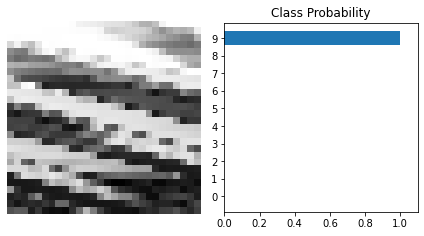

In [28]:
dataiter = iter(testloader)

images,labels = dataiter.next()

index = 3
logps = model(images[index].unsqueeze(0)) #(3,32,32) --> (1,3,32,32)
ps = torch.exp(logps)

view_classify(images[index],ps)